# Unsupervised learning - dimensionality reduction
## Applications of Principal component analysis PCA

Follow:
- _Introduction to Machine Learning_ [Chapter 3](https://github.com/amueller/introduction_to_ml_with_python/blob/master/03-unsupervised-learning.ipynb) **Section 3.4.1 Principal Component Analysis** (p.149-155)
- _Python Data Science Handbook_ [Chapter 5 In Depth: Principal Components Analysis](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.09-Principal-Component-Analysis.ipynb) (p.437-442)






In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import mglearn

## PCA for visualization: Handwritten digit dataset
code from Python Data Science Handbook Chapter 5:[Principal Component Analysis](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.09-Principal-Component-Analysis.ipynb)

8x8 images of handwritten digits are stored as vectors of length 64. Each vector component (pixel) is a feature. All image vectors are stacked in a feature matrix X. How to visualize this dataset with 64 columns?

Use PCA to reduce to 2 dimensions and plot rows in this new 2D space.

In [3]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [4]:
from sklearn.decomposition import PCA

pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


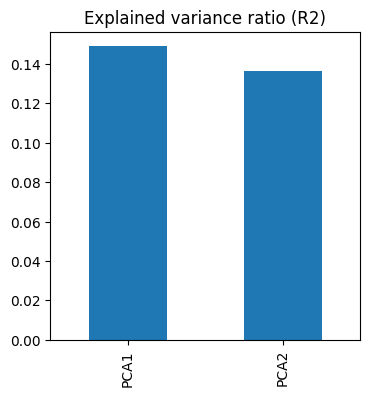

In [5]:
ax = pd.DataFrame(pca.explained_variance_ratio_, index=['PCA1', 'PCA2']).plot.bar(legend=False, figsize=(4,4))
ax.set_title('Explained variance ratio (R2)');

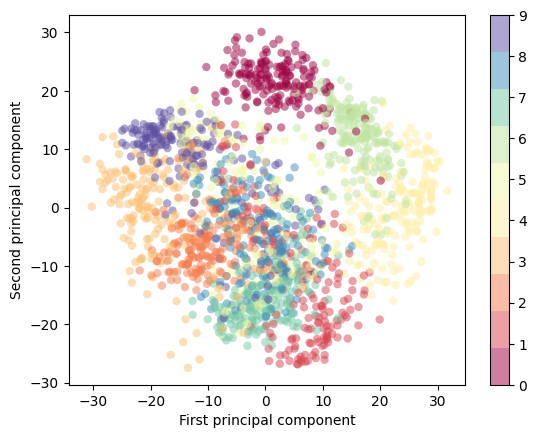

In [6]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, 
            cmap=plt.cm.get_cmap('Spectral', 10),
            edgecolor='none', 
            alpha=0.5)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.colorbar();

In [7]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, zoom =1, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    ax.set_xlabel('First principal component')
    ax.set_ylabel('Second principal component')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], zoom=zoom,cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

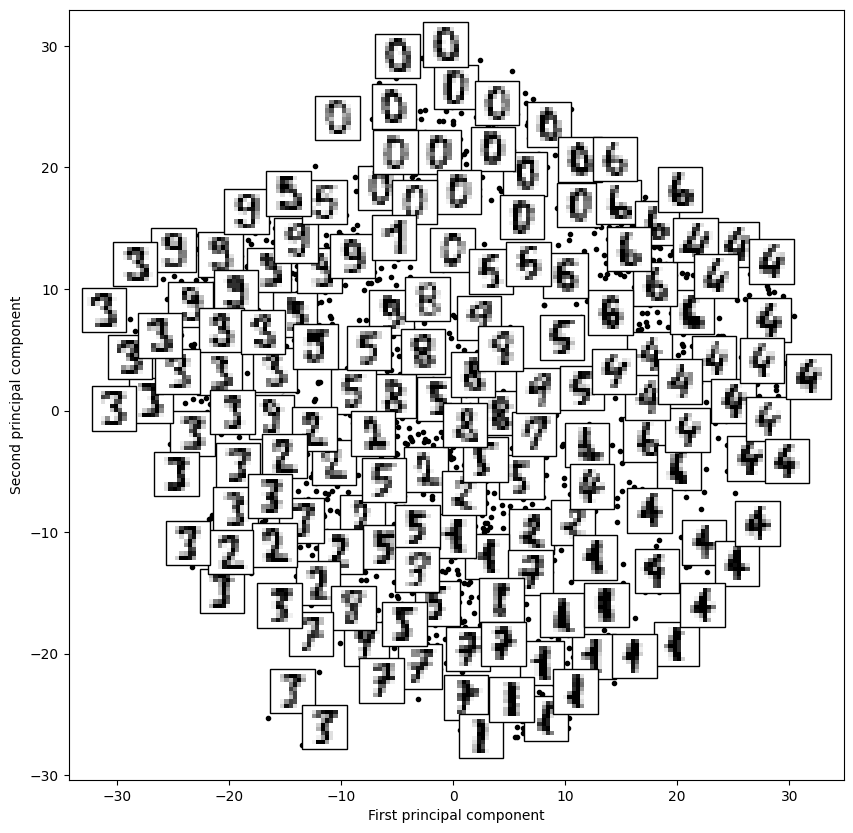

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(digits.data,
                model=pca,
                images=digits.data.reshape((-1, 8, 8)),
                ax=ax, thumb_frac=0.05, zoom=3, cmap='gray_r')

### How many components should we choose?

For visualization, we can at most choose 3.

For feature engineering, we would choose the number necessary to explain a defined amount of variance.


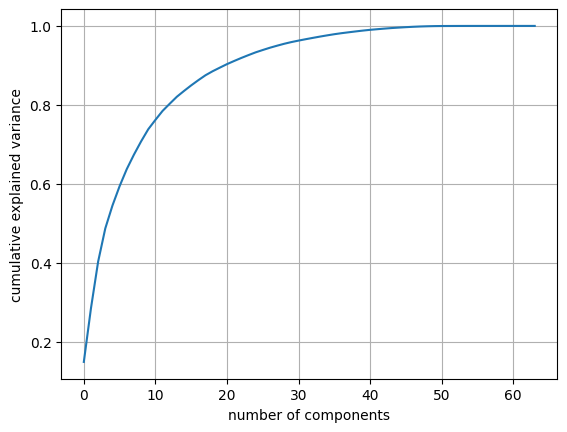

In [9]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid(True)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');


## PCA for feature extraction: Eigenfaces
Introduction to Machine Learning with Python [Chapter 3.4.1](https://github.com/amueller/introduction_to_ml_with_python/blob/master/03-unsupervised-learning.ipynb)

This example aims to identify the person with an face image:
- 1-NN classifier: Builds a database of known faces
- Given a new image, the name associated with the closest image is returned.
- The *Labeled Faces in the Wild* dataset has face images of 62 people
- Randomly guessing would give an accuracy of 1/62=1.6%


### Labeled faces in the wild dataset

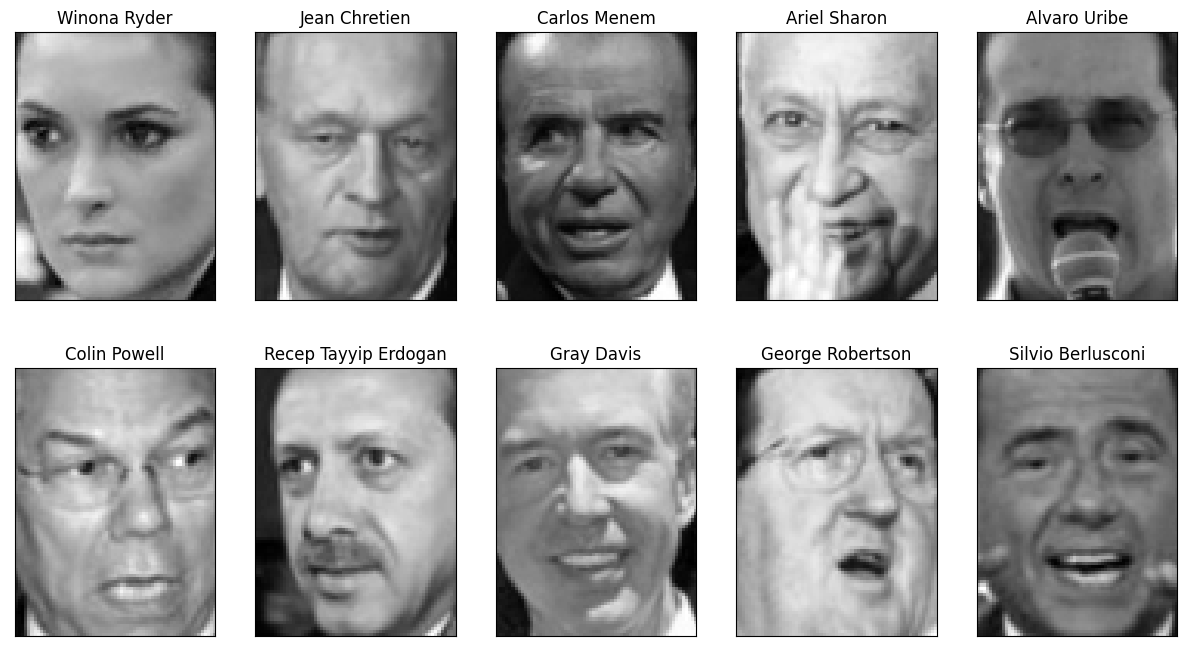

In [10]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image, cmap='gray')
    ax.set_title(people.target_names[target])

In [11]:
print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}".format(len(people.target_names)))

people.images.shape: (3023, 87, 65)
Number of classes: 62


In [12]:
# count how often each target appears
counts = np.bincount(people.target)
# print counts next to target names:
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end='   ')
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo           39   Alvaro Uribe               35   Amelie Mauresmo            21   
Andre Agassi               36   Angelina Jolie             20   Ariel Sharon               77   
Arnold Schwarzenegger      42   Atal Bihari Vajpayee       24   Bill Clinton               29   
Carlos Menem               21   Colin Powell              236   David Beckham              31   
Donald Rumsfeld           121   George Robertson           22   George W Bush             530   
Gerhard Schroeder         109   Gloria Macapagal Arroyo    44   Gray Davis                 26   
Guillermo Coria            30   Hamid Karzai               22   Hans Blix                  39   
Hugo Chavez                71   Igor Ivanov                20   Jack Straw                 28   
Jacques Chirac             52   Jean Chretien              55   Jennifer Aniston           21   
Jennifer Capriati          42   Jennifer Lopez             21   Jeremy Greenstock          24   
Jiang Zemin                20 

### Data pre-processing
- Select at most 50 images from all people.
- Normalize images

In [13]:
mask = np.zeros(people.target.shape, dtype=bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

# scale the grey-scale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability:
X_people = X_people / 255.

In [14]:
X_people.shape

(2063, 5655)

### Exploring faces

In [15]:
y_people

array([61, 25,  9, ...,  9, 37, 22], dtype=int64)

In [16]:
people.target_names[y_people]

array(['Winona Ryder', 'Jean Chretien', 'Carlos Menem', ...,
       'Carlos Menem', 'Laura Bush', 'Igor Ivanov'], dtype='<U25')

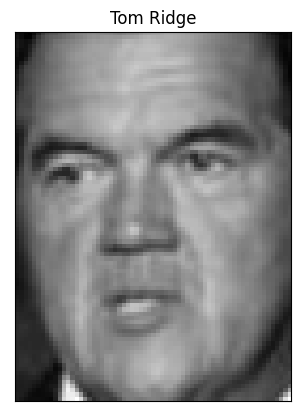

In [17]:
idx = 50
plt.imshow(X_people[idx,:].reshape(image_shape), cmap='gray')
plt.xticks(())
plt.yticks(())
plt.title(people.target_names[y_people[idx]]);

### Find the closest face using 1-nearest neighbor classifier

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


# split the data in training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X_people, y_people, stratify=y_people, random_state=0)

print(f"Training set shape= {X_train.shape}")
print(f"Test set shape={X_test.shape}")

Training set shape= (1547, 5655)
Test set shape=(516, 5655)


In [19]:
# build a KNeighborsClassifier with using one neighbor:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print("Test set score of 1-nn: {:.2f}".format(knn.score(X_test, y_test)))

Test set score of 1-nn: 0.22


>We obtain an accuracy of 23%, which is not actually that bad for a 62-class classification problem (random guessing would give you around 1/62 = 1.6% accuracy), but is also not great. We only correctly identify a person every fourth time.

### KNN uses distance. Does a different normalization help?
Let's use the original data, which is normalized to [0,1] and scale it with a `StandardScaler`, then pass to 1-NN.

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# build a KNeighborsClassifier with using one neighbor:
knn_scaled = KNeighborsClassifier(n_neighbors=1)
knn_scaled.fit(X_train_scaled, y_train)
print("Test set score of 1-nn with scaled features: {:.2f}".format(knn_scaled.score(X_test_scaled, y_test)))

Test set score of 1-nn with scaled features: 0.23


So, yes, StandardScaling helps, increasing accuracy from 23% to 26%.

### Extract features with PCA

With PCA we can:
1. Find a better basis and reduced the number of features,
2. *Whiten* the data which has the same effect as applying a `StandardScaler` **after** PCA transformation. In oother words: PCA+Whiten = PCA + StandardScaler

We saw that scaled features improves performance and we can, hopefully, further improve by using PCA

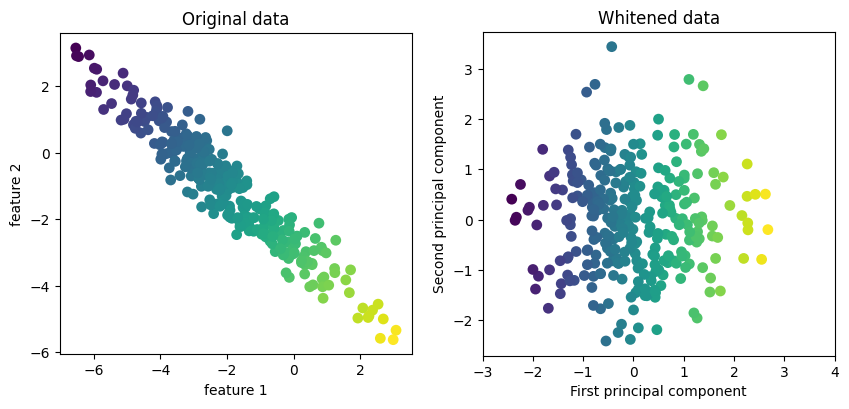

In [21]:
mglearn.plots.plot_pca_whitening()

In [22]:
pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("X_train_pca.shape: {}".format(X_train_pca.shape))

X_train_pca.shape: (1547, 100)


In [23]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)
print("Test set accuracy: {:.2f}".format(knn.score(X_test_pca, y_test)))

Test set accuracy: 0.30


Using PCA with whitening improves the accuracy to 31%, surprisingly with only 100 features, as compared to >5000 features initially.

### Confusion matrix

<AxesSubplot: >

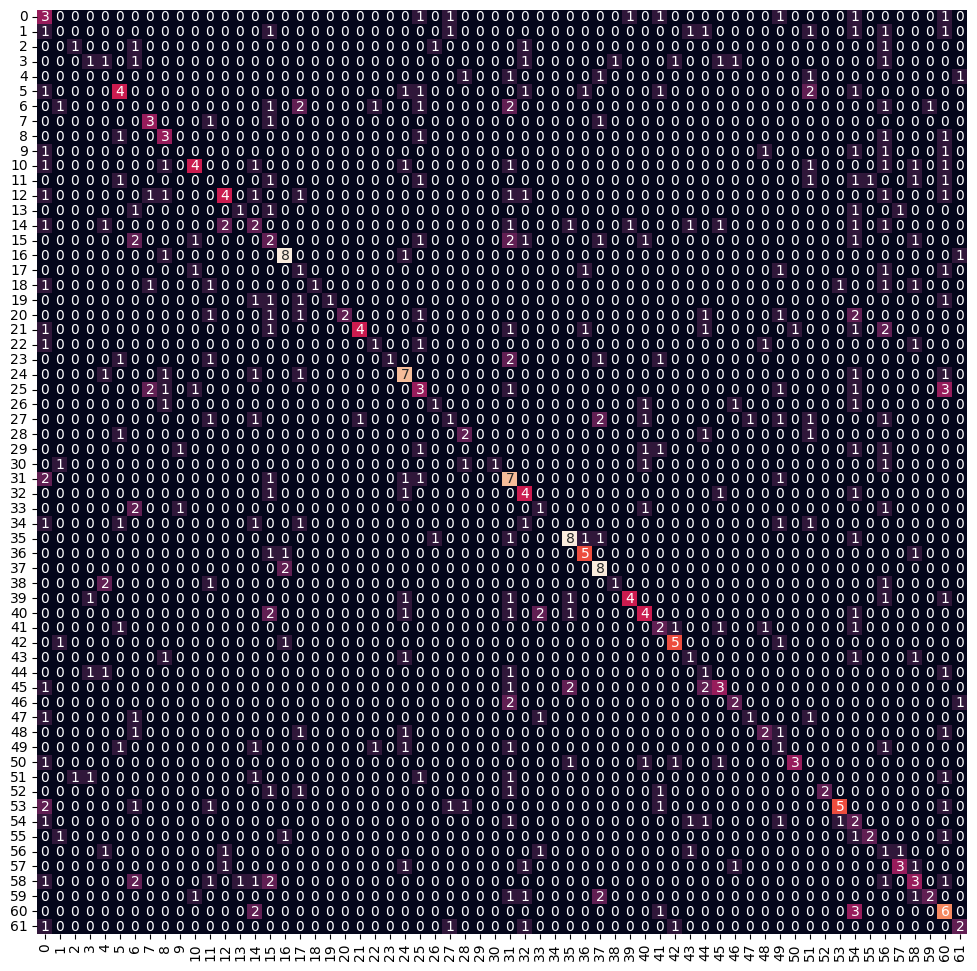

In [24]:
from sklearn.metrics import confusion_matrix

#TODO: reduce the number of labels
mat = confusion_matrix(y_test, knn.predict(X_test_pca))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12))
sns.heatmap(mat, annot=True, fmt='d', cbar=False, ax=ax)

## PCA for noise reduction 
code from Python Data Science Handbook Chapter 5:[Principal Component Analysis](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.09-Principal-Component-Analysis.ipynb)

### Original data

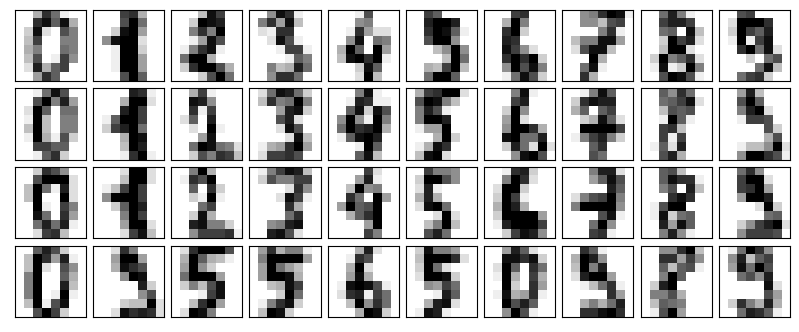

In [25]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

### Added noise

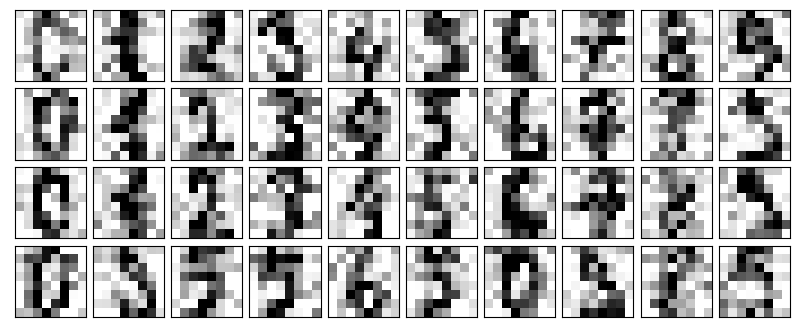

In [26]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

### Denoising with PCA

Assumption: Most of the variance is due to the signal, components with smaller eigenvalues (explained variance) are the noise components.

**Note:** when we pass a float value between 0 and 1 to PCA in the `n_components` parameter, we ask PCA to determine the number of components that explains at least `n_components` percent, i.e. passing 0.5 we would like to explain 50% of the variance.

Here, 12 components are needed. We reduce from 64 dimensions to 12.


In [27]:
pca = PCA(0.60).fit(noisy)
pca.n_components_

18

For denoising, we:
1. Project to reduced space `transform()`
2. Transform back to original space `inverse_transform()`

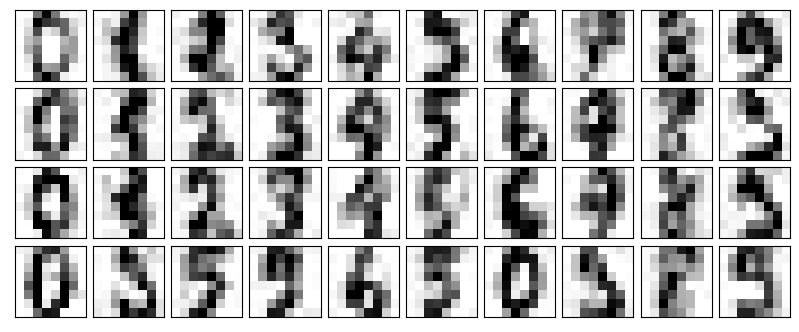

In [28]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)